In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from nilearn import image
from scipy.spatial.distance import euclidean, correlation,squareform
from nilearn.glm.thresholding import threshold_stats_img
from nilearn import plotting
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests, fdrcorrection
from os.path import join as opj

/home/javi/Documentos/software/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
mask_img = "../data/masks/grey_mask_motion_035.nii.gz"

In [3]:
def load_results(task_id, contrast, mask_img, height_control="fdr", alpha = 0.05, cluster_threshold = 50):
    
    base_dir = opj("../results/second-level/node/task-%s" % task_id, contrast)
    
    res_second = dict()
    for name in ["stat", "z_score", "p_value"]:
        res_second[name] = image.load_img(opj(base_dir, "%s.nii.gz" % name))
        
    z_thr, thr = threshold_stats_img(res_second["z_score"],  
                                     mask_img = mask_img,
                                     height_control = height_control,
                                     alpha = alpha,
                                     cluster_threshold = cluster_threshold)
    res_second['z_score_thr'] = z_thr
    
    res_second['stat_thr'] = image.math_img("img1*(abs(img2) > %f)" % thr, 
                                            img1 = res_second["stat"], 
                                            img2 = res_second["z_score"])    
    return res_second

In [4]:
stroop_second = load_results(task_id = "stroop", 
                             contrast = "Incongruent-Congruent",
                             mask_img = mask_img)
msit_second = load_results(task_id = "msit", 
                           contrast = "Incongruent-Congruent",
                           mask_img = mask_img)

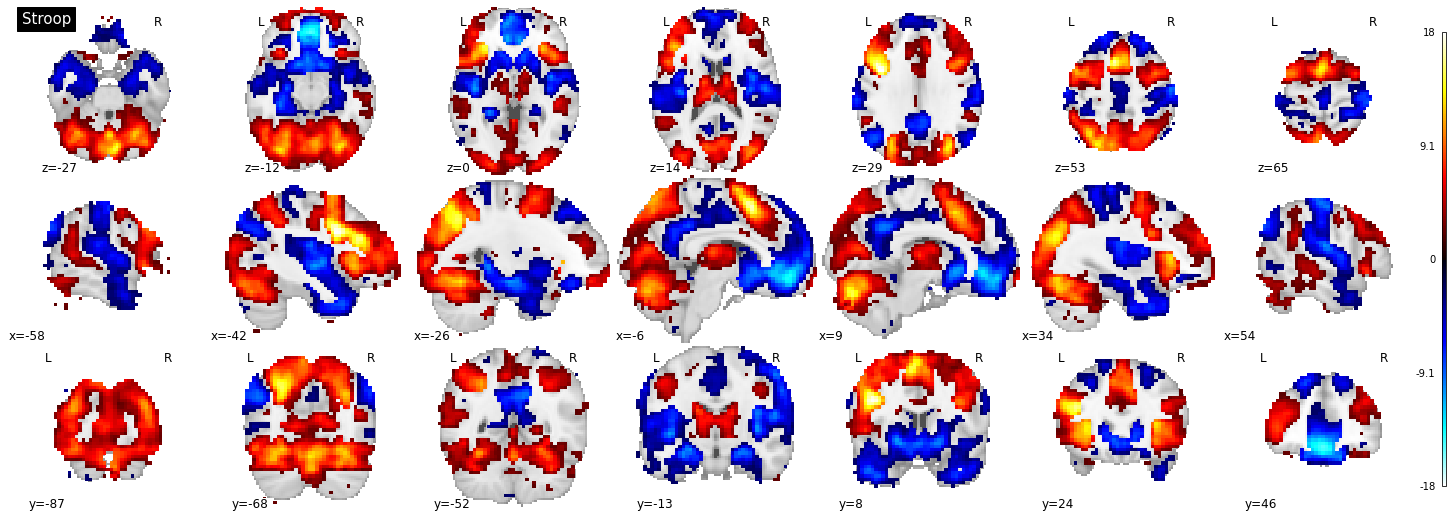

In [5]:
fig = plt.figure(figsize=(20, 7))
plotting.plot_stat_map(stroop_second['stat_thr'], 
                       title = "Stroop", display_mode= 'mosaic', 
                       cut_coords = 7, colorbar=True, figure=fig)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50.png")
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50.svg")
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50.pdf")

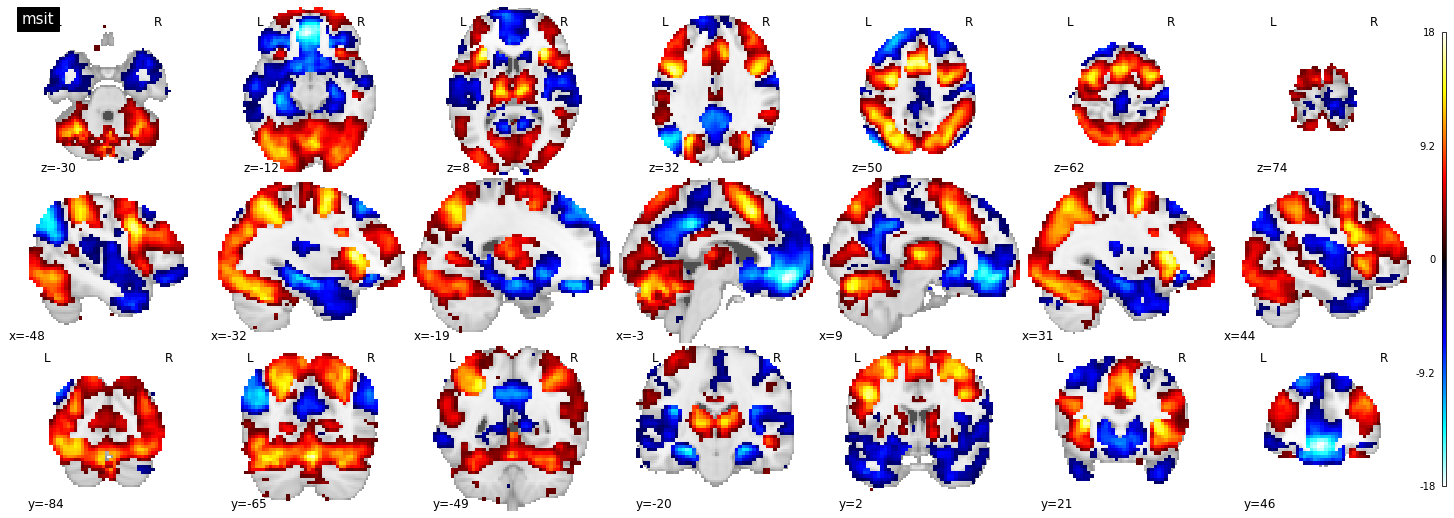

In [7]:
fig = plt.figure(figsize=(20, 7))
plotting.plot_stat_map(msit_second['stat_thr'], 
                       title = "msit", display_mode= 'mosaic', 
                       cut_coords = 7, colorbar=True, figure=fig)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50.png")
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50.svg")
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50.pdf")

## Get activation peaks (positive and negative), to be later used as seed for connectivity


In [8]:
import json

In [9]:
def get_peaks(img):
    img_data = img.get_fdata()
    
    pos_peak_coords = np.where(img_data == np.max(img_data))
    pos_peak_coords = tuple(np.concatenate(pos_peak_coords)) # Convert to tuple
    
    neg_peak_coords = np.where(img_data == np.min(img_data))
    neg_peak_coords = tuple(np.concatenate(neg_peak_coords)) # Convert to tuple
    
    # Convert this to physical coordinates
    pos_peak_coords_mni = image.coord_transform(*pos_peak_coords, affine=img.affine)
    neg_peak_coords_mni = image.coord_transform(*neg_peak_coords, affine=img.affine)
    peaks_mni = {'positive': pos_peak_coords_mni,  'negative': neg_peak_coords_mni}
    return peaks_mni

In [10]:
peaks_stroop = get_peaks(stroop_second['stat_thr'])
print(peaks_stroop)
with open("../results/second-level/node/task-stroop/Incongruent-Congruent/peaks.json", "w") as f:
    json.dump(peaks_stroop, f)
    
peaks_msit = get_peaks(msit_second['stat_thr'])
print(peaks_msit)
with open("../results/second-level/node/task-msit/Incongruent-Congruent/peaks.json", "w") as f:
    json.dump(peaks_msit, f)

{'positive': (-42.04899883270264, 5.229002952575684, 29.5), 'negative': (-0.40999794006347656, 46.868003845214844, -12.5)}
{'positive': (2.793002128601074, -65.23699855804443, -21.5), 'negative': (-3.6129980087280273, 46.868003845214844, -12.5)}


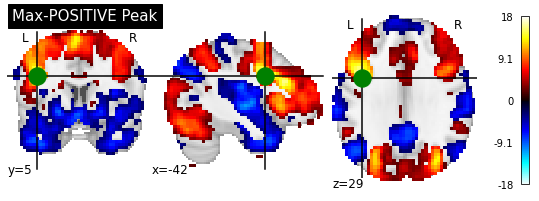

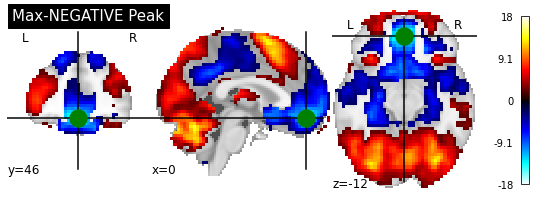

In [11]:
display = plotting.plot_stat_map(stroop_second['stat_thr'], 
                                 cut_coords = peaks_stroop['positive'], title="Max-POSITIVE Peak")
display.add_markers(marker_coords=[peaks_stroop['positive']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.pdf", dpi=300)

display = plotting.plot_stat_map(stroop_second['stat_thr'], 
                                 cut_coords = peaks_stroop['negative'], title="Max-NEGATIVE Peak")
display.add_markers(marker_coords=[peaks_stroop['negative']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.pdf", dpi=300)

In [ ]:
display = plotting.plot_stat_map(msit_second['stat_thr'], 
                                 cut_coords = peaks_msit['positive'], title="Max-POSITIVE Peak")
display.add_markers(marker_coords=[peaks_msit['positive']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.pdf", dpi=300)

display = plotting.plot_stat_map(msit_second['stat_thr'], 
                                 cut_coords = peaks_msit['negative'], title="Max-NEGATIVE Peak")
display.add_markers(marker_coords=[peaks_msit['negative']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.pdf", dpi=300)